# **Modelado Clasificación**

Este notebook tiene como proposito abordar la tarea de clasificación. Para esto inicialmente se experimentan varias técnicas de reducción de dimensionalidad con el proposito de óptimizar los recursos informativos, como resultado de los experimentos se selecciona una técnica de reducción que conserve mejor la variabilidad de los datos y a su vez tenga mejor desempeño computacional. Seguido se evaluan diferentes modelos de clasificación, inicialmente los modelos serán sometidos a dos fases sucesivas para determinar los parámetros óptimos a implementar y asi optimizar las métricas de Machine learning definidas para los modelos de regresión, finalmente se selecciona el modelo que mejor desempeño tenga según la curva ROC.

# **Reducción de dimensionalidad en modelo de Clasficiación**

En esta sección se tiene como propósito reducir las dimensiones del dataset obtenido del colab 00. creacion_análisis_y_tratamiento_datos. Por lo anterior, se plantean dos objetivos:

  1. La conservación de las características más aportantes para los modelos de clasificación.
  2. Mejorar la eficiencia de recursos en la implementación de los algoritmos de clasificación. 

Para experimentar entre las técnicas de reducción, se planteó la siguiente metodología: 

1. En todos los experimentos se evaluará un modelo de  árbol de decisión regresor, este con el  objetivo de evaluar en un modelo más  sofisticado si algún  método de reducción se ajusta potencialmente mejor.

2. Se evaluará el desempeño de los modelos anteriormente mencionados con el dataset completo para obtener los valores de desempeño iniciales. 

3. Se realizará una reducción de filas extrayendo aleatoriamente el 50% de las filas del dataset inicial y se evaluarán los modelos mencionados en el literal 1. 

4. Se realizará una reducción de columnas por medio de tres técnicas: 
    * Xgboost
    * Xgboost permutation
    * Xgboost Shap.

5. Se compararán los resultados obtenidos de los experimentos y se escogerán los resultados que más se ajusten a los objetivos inicialmente planteados. 






 

##**Descarga de paquetes**

In [1]:
#LRS &OSR Se descargan los paquetes pandas, numpy, matplotlib y sklearn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score
import time

In [2]:
!git clone https://github.com/LuisPortela/ELO.git #LPS & OSR: se clona el repostorio que alberga el documento json para hacer la lectura de datos directamente 
import zipfile                                     #           del API de kaggel
import os
import pandas as pd
os.environ['KAGGLE_CONFIG_DIR'] = "/content/ELO"

Cloning into 'ELO'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 44 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (44/44), done.


In [3]:
#LPS&OSR Se realiza la lectura del archivo 01_DB.gz 
ELO_DB = pd.read_csv('ELO/01_DB.gz', compression='gzip', header=0, sep=',')

In [4]:
#LPS&OSR Se elimina la columna  "unnamed:0" obtenida por defecto
ELO_DB.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
#LPS &OSR: Se visualiza las dos primeras filas del dataset inicial
ELO_DB.head(2)

,max(count_authorized_flag),avg(count_category_1),sum(count_category_1),avg(installments),sum(installments),max(month_lag),stddev_samp(month_diff_hist),city_id_nunique,authorized_flag_mean,authorized_flag_amax,...,feature_1(2),feature_1(3),feature_1(4),feature_1(5),feature_2(1),feature_2(2),feature_2(3),feature_3(0),feature_3(1),target
0,0.0,-0.484760,-0.332932,-0.770803,-0.588104,-1.675451,-1.521967,-0.184872,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.078485
1,0.0,0.030289,-0.169953,1.436304,0.180519,0.244507,-1.521967,1.069501,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.014108


In [6]:
#LPS &OSR: Se imprimen las dimensiones del dataset inicial
ELO_DB.shape

(167758, 33)

## **Creación de la variable: Target Discreta**

Debido a que el dataset no cuenta con la clasificación de lealtad explicada por clases, nos disponemos a  discretizar  los valores de la variable lealtad que tiene una distribución continua, teniendo como punto de referencia el signo asociado a cada valor de la lealtad. Esto permitió la creación de dos clases, siguiendo el siguiente criterio:si la variable target(lealtad) tiene un valor inferior a 0 se le asignará la clase 0 de lo contrario se le asignará el valor 1. 





/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


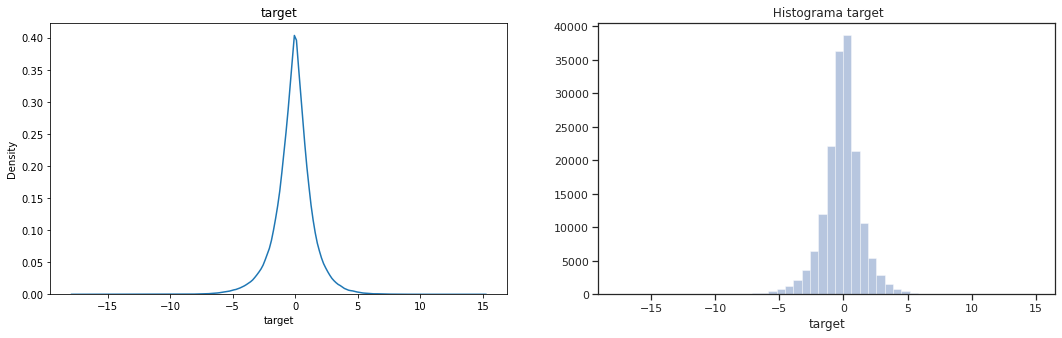

In [7]:
# LPS &OSR: Se realiza un diagrama de densidad y un histograma de la variable target(fidelidad)
fig= plt.figure(figsize=(18,5))
ax1= fig.add_subplot(121)
sns.set_theme(style="ticks")
sns.kdeplot(ELO_DB['target']).set(title= 'target')
ax1= fig.add_subplot(122)
sns.distplot(ELO_DB['target'], kde=False, rug=False).set(title=' Histograma target')
plt.show()

A partir del gráfico univariable de “Fidelidad” como variable de respuesta continua, se evidencia que la distribución de esta característica es perfectamente simétrica, centrada en 0 y con colas robustas, lo cual indica la presencia de datos atípicos residuales del proceso de eliminación de outliers llevado a cabo en el preprocesamiento de los datos.

Como se expuso previamente, la variable Target “Fidelidad”, es un score normalizado cuyo signo define el tipo de lealtad. En este sentido, se puede deducir, dado que el concurso no lo precisa, que entre mayor sea la magnitud de esta variable, más fuerte será la lealtad a condición de que esta sea positiva. 


In [8]:
#LPS&OSR :Se realiza un resumen estadístico de la variable target(fidelidad)
ELO_DB.describe()['target']

count    167758.000000
mean         -0.119358
std           1.512581
min         -17.492640
25%          -0.847826
50%          -0.050817
75%           0.657477
max          14.855160
Name: target, dtype: float64

La variable target (fidelidad) tiene una media de de -0.11 y esta distribuida en un rango de -17.49 a 14.85.

In [9]:
#LPS &OSR: Se crea la función que discretarizará la variable target.
def discretizacion_target(row):
  if row['target']< 0:
    target= 0
  else:
    target= 1  
  return target

In [10]:
#LPS&OSR: Se aplica la función al dataset ELO_DB
ELO_DB['Target_discreta']=ELO_DB.apply(discretizacion_target, axis=1)

In [11]:
#LPS&OSR: Se verifican los valores alojados en la variablel Target_discreta
ELO_DB['Target_discreta'].unique()

array([0, 1])

In [12]:
#LPS &OSR: Se realiza un conteo de cada clase contenida en la variable Target Discreta
ELO_DB['Target_discreta'].value_counts()

0    87246
1    80512
Name: Target_discreta, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 1.0, 'Diagrama de barras Target Discreta')]

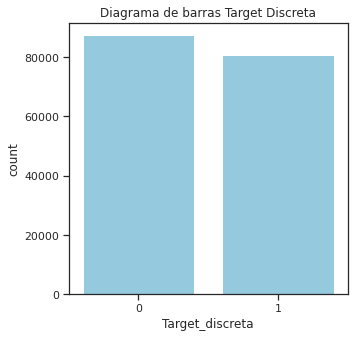

In [13]:
#LPS &OSR: Se realiza un diagrama de barras para visualizar la distribución de la variable Target discreta
fig= plt.figure(figsize=(5,5))
sns.set_theme(style="ticks")
sns.countplot(ELO_DB['Target_discreta'], color="Skyblue").set(title='Diagrama de barras Target Discreta')

En el diagrama de barras asociado a la variable Fidelidad en su forma categórica, se observa que la discretización de la variable a una característica biclase, permite una repartición balanceada del dataset, atribuyendo 87246 registros para la clase 0 (clientes “infieles”) y 80512 para la clase 1 (clientes fieles) representando el 52% y 48% respectivamente.

In [14]:
#LPS&OSR: Se calcula la correlación de la variable Target_discreta con las variables contenidas en el dataframe
DF_correlation_DF_target_discreta=pd.DataFrame(ELO_DB.corrwith(ELO_DB["Target_discreta"]), columns =['Target_discreta'])
#LPS&OSR: Se eliminan las columnas que anteriormente se evidenciaron que aportaban poca información a los datos. 
DF_correlation_DF_target_discreta.drop(index=(['max(count_authorized_flag)',  'authorized_flag_mean','authorized_flag_amax', 'authorized_flag_std', 'target','Target_discreta']), inplace=True)

In [15]:
#LPS&OSR Se imprime el dataframe con las correlaciones anteriormente calculadas. 
DF_correlation_DF_target_discreta

,Target_discreta
avg(count_category_1),0.016864
sum(count_category_1),0.004312
avg(installments),0.040734
sum(installments),0.008605
max(month_lag),-0.033418
stddev_samp(month_diff_hist),-0.022967
city_id_nunique,-0.115056
purchase_amount_mean,-0.094967
purchase_amount_amax,-0.132080
purchase_amount_sum,0.107533


Se puede evidenciar que ninguna variable tiene algún tipo de relación con la variable **Target_discret**

In [16]:
#LPS &OSR Se instancian los índices  para dividir datos 
Kf= KFold(n_splits=3)

In [17]:
#LPS &OSR Se realiza una copia del DataFrame inicial 
X= ELO_DB.copy()
#LPS &OSR Se elimina la columna target y se asigna el dataframe a la variable X
X= X.drop(columns=['target', 'Target_discreta']) 
#LPS &OSR  se instancia la variable Y con la serie de la columna targe
Y= ELO_DB['Target_discreta']      
#LPS&OSR: Los datos se se dividen en train y trest con el 20% de datos para test. 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 17)

## **1. Dataset inicial**

Con el proposito de obtener una base de comparación, se realiza la implementación con la totalidad de los datos de un modelo de arbol de decisión classifier, en el cual se efectuará la busqueda de hiperparametros.

Los resultados serán almacenados para posteriormente ser comparados en los resultados obtenidos en las demás modalidades de reducción.

### **1.1 Decision Tree Classifier**

In [18]:
# LPS &OSR Se instancian los parámetros para posteriormente hacer  la busqueda valores de óptimos específicos para un estimador
parameters={"criterion": ['gini', 'entropy'],
            "splitter":["best"],
            "max_depth" : [None, 3,7,20],
            "min_samples_split":[3,7, 40],
            "min_samples_leaf":[1,5,9, 20],
            "max_features":["log2","sqrt",None],
            "max_leaf_nodes":[None,10,50,70,90] }

In [19]:
#%%time
#LPS &OSR Se instancia el modelo DecisionTree Regressor con un randon_state=42 para obtener siempre las mismas características
class_decision_model=DecisionTreeClassifier(random_state=42)
#LPS&OSR: Se guarda el tiempo antes de iniciar el gridsearch
start_time = time.time()
#LPS&OSR se realiza la busqueda de hiperparametros para el modelo DecisionTreeRegressor por medio de un gridsearch, se intancia ROC_AUC como medida de evaluación 
tuning_model=GridSearchCV(class_decision_model,param_grid=parameters,scoring='roc_auc',cv=Kf,verbose=3, n_jobs=-1, return_train_score=True)
tuning_model.fit(X_train,Y_train)
time_Full=(time.time() - start_time)

Fitting 3 folds for each of 1440 candidates, totalling 4320 fits


In [20]:
#LPS &OSR: se imprimen los mejores parámetros obtenidos y el score de validación
print(tuning_model.best_params_)
print('Score de validation',tuning_model.best_score_)

{'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': 90, 'min_samples_leaf': 20, 'min_samples_split': 3, 'splitter': 'best'}
Score de validation 0.642442824370478


In [21]:
#LPS &OSR: Se guardan en una variable los resultados del cross validation.
DT_results=tuning_model.cv_results_
df=pd.DataFrame(DT_results)#LPS &OSR: Los resultados se guardan en un dataframe
df[df['params']==tuning_model.best_params_]['mean_train_score']#LPS&OSR: Se filtan los mejores parametros y se implimen

897    0.658465
Name: mean_train_score, dtype: float64

Se puede evidenciar según el score obtenivo en la curva ROC (0.658), que durante el entrenamiento que se obtiene una clasificación de las clases regular.

In [22]:
#LPS&OSR: Se guardan en la variable mean_train_score los resultados obtenidos con la mejor combinación de hiperparametros
mean_train_score=float(df[df['params']==tuning_model.best_params_]['mean_train_score'].values[0])

In [23]:
#LPS&OSR: Se intancia el modelo  DecisionTreeClassifier con los mejores hiperparametros y se justa el modelo. El criterio usado para evaluar la calidad del slip es entropy
tuned_hyper_model= DecisionTreeClassifier(criterion='entropy',max_depth=None, max_features=None,max_leaf_nodes=90,min_samples_leaf=20, min_samples_split=3, splitter='best')
tuned_hyper_model.fit(X_train,Y_train)
y_pred_DTR=tuned_hyper_model.predict(X_test)

In [24]:
#LPS&OSR: Se imprime el valor optenido de la Curva ROC  al comparar las predicciones con los valores de test
print('ROC_AUC = '+str(roc_auc_score(Y_test,y_pred_DTR)))

ROC_AUC = 0.6097773275605344


Se puede constatar que la discriminación de las clases es regular, debido a que evaluando los datos de test se obtiene un valor de score 0.609.

[('Normalized confusion matrix', 'true')]
[[0.61858625 0.38141375]
 [0.3990316  0.6009684 ]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


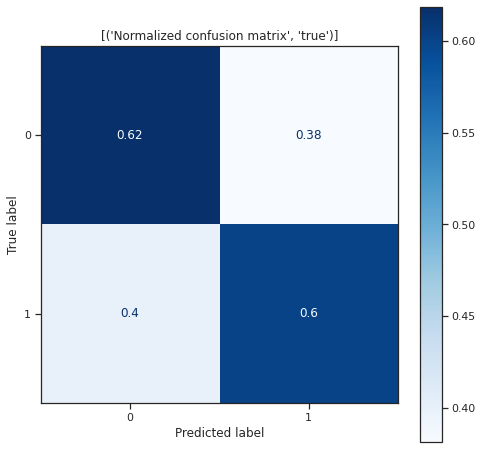

In [25]:

#LPS&OSR: Se realiza la matriz de confusión normalizada del modelo clf1 (KNN)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


titles = [("Normalized confusion matrix", 'true')]

#for title, normalize in titles_options:
fig, ax = plt.subplots(figsize=(8, 8))
disp = plot_confusion_matrix(tuned_hyper_model ,X_test, Y_test,
                              display_labels=['0','1'],
                              cmap=plt.cm.Blues,
                              normalize='true', ax=ax)
disp.ax_.set_title(titles)

    
print(titles)
print(disp.confusion_matrix)
plt.show()


A partir del gráfico se puede evidenciar que la clase 0 (Valores de la variable target(Fidelidad) inferiores a 0) fue clasificada el 62%  de las veces correctamente, a su vez la clase 1 (Valores de la variable target(Fidelidad) iguales o superiores a 0) fue clasificada el 60& de las veces correctamente. 

In [26]:
#LPS &OSR: Se guardan lso datos obtenidos en el modelo decision tree classifier
#LPS &OSR: se guarda el score de train, el score de test y el tiempo de ejecución
summary_results=[]
Full_DB= ["Full data frame",mean_train_score]
Full_DB.append(roc_auc_score(Y_test, y_pred_DTR))
Full_DB.append(time_Full)
#LPS&OSR : Se guardan los valores en la lista inicial
summary_results.append(Full_DB)

## **2. Row Reduction**

Se implementa el primer método de reducción (Row Reduction), el cual consiste en extraer el 50% de los datos del dataset inicial de forma aleatoria. Igualmente se realiza la implementación del modelo de clasificación Decision Tree Classifier con los datos obtenidos despues de aplicar el método.

Los resultados serán almacenados para posteriormente ser comparados en los resultados obtenidos en las demás modalidades.

In [27]:
#LPS &OSR: Se realiza la reducción de filas extrayendo una muestra que contiene el 50% de los datos
ELO_DB_row_reduction = ELO_DB.sample(frac=0.50, replace=False, random_state=42)

In [28]:
# LPR&OSR Se constata que se haya extraido el 50% de los datos
ELO_DB_row_reduction.shape[0]

83879

In [29]:
#LPS &OSR Se hace una copia del DataFrame inicial 
X= ELO_DB.copy()
#LPS &OSR Se elimina la columna target y se asigna el dataframe resultante a la variable X
X= X.drop(columns=['target', 'Target_discreta']) 
#LPS &OSR  se instancia la variable Y con la serie de la columna target
Y= ELO_DB['Target_discreta']      
#LPS&OSR: Los datos se se dividen en train y trest con el 20% de datos para test. 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 17)

### **2.1 Decision Tree Classifier**

In [30]:
# LPS &OSR Se instancian los parametros para posteriormente hacer  la busqueda valores de parámetros específicos para un estimador
parameters={"criterion": ['gini', 'entropy'],
            "splitter":["best"],
            "max_depth" : [None, 3,7,20],
            "min_samples_split":[3,7, 40],
            "min_samples_leaf":[1,5,9, 20],
            "max_features":["log2","sqrt",None],
            "max_leaf_nodes":[None,10,50,70,90] }

In [31]:

#LPS &OSR Se instancia el modelo DecisionTree Regressor con un randon_state=42 para obtener siempre las mismas caracteristicas
class_decision_model=DecisionTreeClassifier(random_state=42)
#LPS&OSR: Se guarda el tiempo antes de iniciar el gridsearch
start_time = time.time()
#LPS&OSR se realiza la busqueda de hiperparametros para el modelo DecisionTreeRegressor por medio de un gridsearch, se intancia ROC_AUC como medida de evaluación 

tuning_model_RR=GridSearchCV(class_decision_model,param_grid=parameters,scoring='roc_auc',cv=Kf,verbose=3, n_jobs=-1, return_train_score=True)
tuning_model_RR.fit(X_train,Y_train)
time_RR=(time.time() - start_time)

Fitting 3 folds for each of 1440 candidates, totalling 4320 fits


In [32]:
#LPS &OSR: se imprimen los mejores parametros obtenidos y el score de validación
print(tuning_model_RR.best_params_)
print('Score de validation',tuning_model_RR.best_score_)

{'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': 90, 'min_samples_leaf': 20, 'min_samples_split': 3, 'splitter': 'best'}
Score de validation 0.642442824370478


In [33]:
#LPS &OSR: Se guardan lso datos obtenidos en el modelo decision tree regressor
#LPS &OSR: se guarda el score de train, el score de test y el tiempo de ejecución
#LPS&OSR : Se guardan los valores en la lista inicial
DT_RR_results=tuning_model_RR.cv_results_
DF_RR=pd.DataFrame(DT_RR_results)
DF_RR[DF_RR['params']==tuning_model_RR.best_params_]['mean_train_score']

897    0.658465
Name: mean_train_score, dtype: float64

Se puede evidenciar según el score obtenivo en la curva ROC (0.658), que durante el entrenamiento que se obtiene una clasificación de las clases regular.

In [34]:
#LPS&OSR: Se guardan en la variable mean_train_score_RR los resultados obtenidos con la mejor combinación de hiperparametros
mean_train_score_RR=float(DF_RR[DF_RR['params']==tuning_model_RR.best_params_]['mean_train_score'].values[0])

In [35]:
#LPS&OSR: Se intancia el modelo  DecisionTreeClassifier con los mejores hiperparametros y se justa el modelo. El criterio usado para evaluar la calidad del slip es entropy
tuned_hyper_model_RR= DecisionTreeClassifier(criterion= 'entropy',max_depth=None,max_features=None,max_leaf_nodes=90,min_samples_leaf=20, min_samples_split=3, splitter='best')
tuned_hyper_model_RR.fit(X_train,Y_train)
y_pred_DTR_RR=tuned_hyper_model_RR.predict(X_test)

In [36]:
#LPS &OSR: Se guardan lso datos obtenidos en el modelo decision tree classifier
#LPS &OSR: se guarda el score de train, el score de test y el tiempo de ejecución
ROW_RED= ["Row reduction",mean_train_score_RR]
ROW_RED.append(roc_auc_score(Y_test, y_pred_DTR_RR))
ROW_RED.append(time_RR)
summary_results.append(ROW_RED)

## **3. Feature Reduction**

Para esta sesión se implementará el segundo método (feature reduction) el cual se desarrollará por medio del algoritmo Xgboost, el cual brinda un conjunto de métodos de árboles de decisión, como lo es el gradient boosting, proporcionando las estimaciones de importancia de las caracteristicas a partir de un modelo predictivo entrenado.

En esta etapa se evaluarán tres variaciones:

* Xgboost
* Xgboost permutation, excluira aleatoriamente cada función y calculará el cambio en el rendimiento del modelo. Las características que más afectan el rendimiento son las más importantes.
* Xgboost Shap, el cual utiliza los valores de Shapley de la teoría de juegos para estimar cómo contribuye cada característica a la predicción.
Del mismo modo, se realiza la implementación de modelos de regresión con los datos obtenidos despues de aplicar el método.


Se implementara el modelo DecisionTreeClassifier para continuar con la base de comparación inicial.

Los resultados serán almacenados para posteriormente ser comparados en los resultados obtenidos en las demás modalidades.

### **3.1. Xgboost**

https://mljar.com/blog/feature-importance-xgboost/

In [37]:
#LPS &OSR Se hace una copia del DataFrame inicial 
#Se elimina la columna target y se asigna el dataframe a la variable X
#LPS &OSR  se instancia la variable Y con la serie de la columna target
#LPS&OSR: Los datos se se dividen en train y trest con el 20% de datos para test
X= ELO_DB.copy()

X= X.drop(columns=['target', 'Target_discreta']) 
Y= ELO_DB['Target_discreta']      

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 17)

In [38]:
#LPS &OSR: Se intancia el modelo XGBR Classifier inicialmente con 100 arboles de decision
xgb = XGBClassifier(n_estimators=100, random_state=42)
xgb.fit(X_train, Y_train) #LPS&OSR :Se ajusta el modelo

XGBClassifier(random_state=42)

Text(0.5, 0, 'Xgboost Feature Importance')

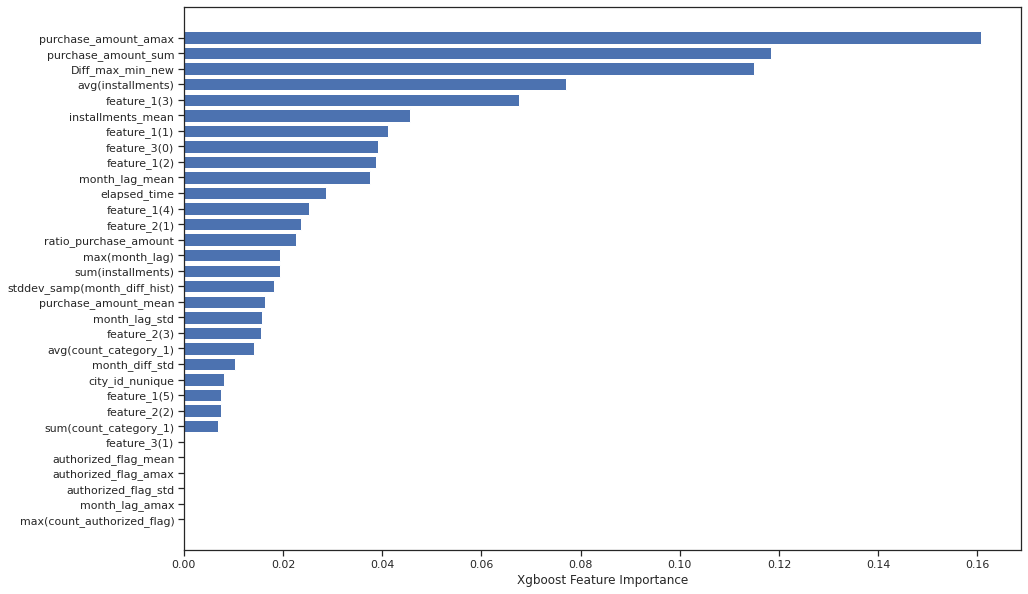

In [39]:
#LPS&OSR: Se establece el tamaño de la figura
#LPS&OSR: Se instancian en una variable   los la importancia de los valores obtenidos del parametro featrure_importance y se organizan de mayor a menor
# LPS&OSR: Se gráfica los valores 

plt.rcParams["figure.figsize"] = (15,10)
sorted_idx = xgb.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

In [40]:
# LPS &OSR: Se concatenan dos dataframe; uno con el nombre de las columans y otro con el valor de la importancia. 
XGBClassifier_1= pd.concat([pd.DataFrame(X.columns[sorted_idx], columns=['Features']),pd.DataFrame(xgb.feature_importances_[sorted_idx],columns=['Importance'] )], axis=1)

In [41]:
#LPS &OSR: Se imprimen los valores de la importancia de las feature calculados por xgboots que sean inferiores a una centésima del feature important mas alto.
XGBClassifier_1[XGBClassifier_1['Importance']<=np.max(XGBClassifier_1['Importance'])/100]

,Features,Importance
0,max(count_authorized_flag),0.0
1,month_lag_amax,0.0
2,authorized_flag_std,0.0
3,authorized_flag_amax,0.0
4,authorized_flag_mean,0.0
5,feature_3(1),0.0


In [42]:
#LPS &OSR: Se instancian las features anteriores a una variable
XGBClassifier_1_features= XGBClassifier_1[XGBClassifier_1['Importance']<=np.max(XGBClassifier_1['Importance'])/100]

In [43]:
#LPS &OSR: Se imprime la longitud de las caracteristicas
len(XGBClassifier_1_features)

6

#### **3.1.1 Decision Tree Classifier**

In [44]:
#LPS & OSR: Se crea una copia del DataFrame Inicial
X= ELO_DB.copy()

In [45]:
#LPS &OSR: Se convierten en lista la serie de features que se seleccionaron como menos representativas
list(XGBClassifier_1_features['Features'])

['max(count_authorized_flag)',
 'month_lag_amax',
 'authorized_flag_std',
 'authorized_flag_amax',
 'authorized_flag_mean',
 'feature_3(1)']

In [46]:
#LPS &OSR: Se eliminan del dataset X las variables que fueron menos representativas según el algoritmo  Xgboots
#LPS& OSR: Se elimina la variable target del dataset 
#LPSR &OSR: Se asigna la variable target  a la variable Y
#LPS&OSR: Los datos se dividen en train y trest con el 20% de datos para test. 
X.drop(columns=list(XGBClassifier_1_features['Features']), inplace=True)
X.drop(columns=['target', 'Target_discreta'], inplace=True) 
Y= ELO_DB['Target_discreta']      

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 17)

In [47]:
# LPS &OSR Se instancian los parametros para posteriormente hacer  la busqueda valores de parámetros específicos para un estimador

parameters={"criterion": ['gini', 'entropy'],
            "splitter":["best"],
            "max_depth" : [None, 3,7,20],
            "min_samples_split":[3,7, 40],
            "min_samples_leaf":[1,5,9, 20],
            "max_features":["log2","sqrt",None],
            "max_leaf_nodes":[None,10,50,70,90] }

In [48]:
#LPS &OSR Se instancia el modelo DecisionTree Classifier con un randon_state=42 para obtener siempre las mismas caracteristicas
#LPS&OSR: Se guarda el tiempo antes de iniciar el gridsearch
#LPS&OSR se realiza la busqueda de hiperparametros para el modelo DecisionTreeRegressor por medio de un gridsearch, se intancia ROC_AUC como medida de evaluación 
class_decision_model_FR_Xg1=DecisionTreeClassifier(random_state=42)

start_time = time.time()

tuning_model_FR_Xg1=GridSearchCV(class_decision_model_FR_Xg1,param_grid=parameters,scoring='roc_auc',cv=Kf,verbose=3, n_jobs=-1, return_train_score=True)
tuning_model_FR_Xg1.fit(X_train,Y_train)
Time_FR_Xg1=(time.time() - start_time)

Fitting 3 folds for each of 1440 candidates, totalling 4320 fits


In [49]:
#LPS &OSR: se imprimen los mejores parametros obtenidos y el score de validación
print(tuning_model_FR_Xg1.best_params_)
print('Score de validation',tuning_model_FR_Xg1.best_score_)

{'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': 90, 'min_samples_leaf': 20, 'min_samples_split': 3, 'splitter': 'best'}
Score de validation 0.642442824370478


In [50]:
#LPS &OSR: Se guardan en una variable los resultados del cross validation
#LPS &OSR: Los resultados se guardan en un dataframe
#LPS&OSR: Se filtan los mejores parametros y se implimen
DT_FR_Xg1_results=tuning_model_FR_Xg1.cv_results_
DT_FR_Xg1=pd.DataFrame(DT_FR_Xg1_results)
DT_FR_Xg1[DT_FR_Xg1['params']==tuning_model_FR_Xg1.best_params_]['mean_train_score']

897    0.658465
Name: mean_train_score, dtype: float64

Se puede evidenciar según el score obtenivo en la curva ROC (0.658), que durante el entrenamiento que se obtiene una clasificación de las clases regular.



In [51]:
#LPS&OSR: Se guardan en la variable mean_train_score_DT_FR_XG1 los resultados obtenidos con la mejor combinación de hiperparametros
mean_train_score_DT_FR_Xg1=float(DT_FR_Xg1[DT_FR_Xg1['params']==tuning_model_FR_Xg1.best_params_]['mean_train_score'].values[0])

In [52]:
#LPS&OSR: Se intancia el modelo  DecisionTreeClassifier con los mejores hiperparametros y se justa el modelo. El criterio usado para evaluar la calidad del slip es entropy
tuned_hyper_model_FR_Xg1= DecisionTreeClassifier(criterion='entropy',max_depth=None,max_features=None,max_leaf_nodes=90,min_samples_leaf=20, min_samples_split=3, splitter='best')
tuned_hyper_model_FR_Xg1.fit(X_train,Y_train)
y_pred_DTR_FR_Xg1=tuned_hyper_model_FR_Xg1.predict(X_test)

In [53]:
#LPS&OSR: Se imprime el valor optenido de la Curva ROC  al comparar las predicciones con los valores de test
roc_auc_score(Y_test, y_pred_DTR_FR_Xg1)

0.6097773275605344

In [54]:
#LPS &OSR: Se guardan lso datos obtenidos en el modelo decision tree classifier
#LPS &OSR: se guarda el score de train, el score de test y el tiempo de ejecución
XG_B= ["Row Xgboost",mean_train_score_DT_FR_Xg1]
XG_B.append(roc_auc_score(Y_test, y_pred_DTR_FR_Xg1))
XG_B.append(Time_FR_Xg1)
summary_results.append(XG_B)

### **3.2. Xgboost Permutation**

La variación con el método de permutación barajará aleatoriamente cada función y calculará el cambio en el rendimiento del modelo. Las características que más afectan el rendimiento son las más importantes.

In [55]:
#LPS &OSR Se hace una copia del DataFrame inicial 
#Se elimina la columna target y se asigna el dataframe a la variable X
#LPS &OSR  se instancia la variable Y con la serie de la columna target
#LPS&OSR: Los datos se se dividen en train y trest con el 20% de datos para test
X= ELO_DB.copy()

X= X.drop(columns=['target', 'Target_discreta']) 
Y= ELO_DB['Target_discreta']      

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 17)

In [56]:
#LPS &OSR: Se intancia el modelo XGBR Classifier inicialmente con 100 arboles de decision y se ajusta el modelo
xgb = XGBClassifier(n_estimators=100, random_state=42)
xgb.fit(X_train, Y_train)

XGBClassifier(random_state=42)

In [57]:
#LPS &OSR: Se calcula la importancia de la permutación del modelo para el modelo Xgboots
perm_importance = permutation_importance(xgb, X_test, Y_test, random_state=42)

Text(0.5, 0, 'Permutation Importance')

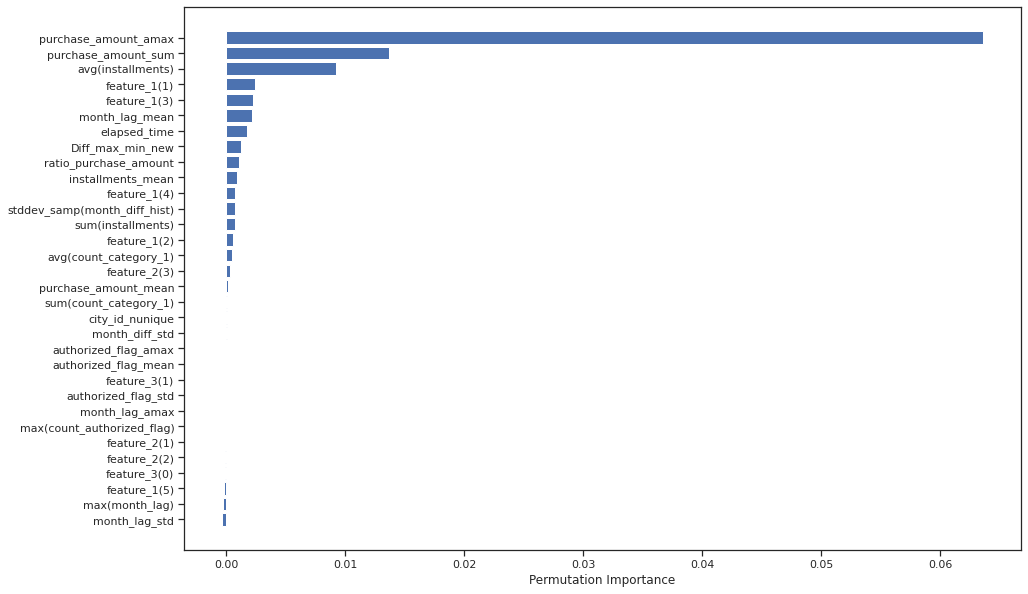

In [58]:

#LPS&OSR: Se establece el tamaño de la figura
#LPS&OSR: Se instancian en una variable   los la importancia de los valores obtenidos del parametro featrure_importance y se organizan de mayor a menor
# LPS&OSR: Se gráfica los valores 
plt.rcParams["figure.figsize"] = (15,10)
sorted_idy = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idy], perm_importance.importances_mean[sorted_idy])
plt.xlabel("Permutation Importance")

In [59]:
# LPS &OSR: Se concatenan dos dataframe; uno con el nombre de las columans y otro con el valor de la importancia. 
XGBClassifier_2= pd.concat([pd.DataFrame(X.columns[sorted_idy], columns=['Features']),pd.DataFrame(perm_importance.importances_mean[sorted_idy],columns=['Importance'] )], axis=1)

In [60]:
#LPS &OSR: Se imprimen los valores de la importancia de las feature calculados por xgboots que sean inferiores a una centésima del feature important mas alto.
XGBClassifier_2[XGBClassifier_2['Importance']<=np.max(XGBClassifier_2['Importance'])/100]

,Features,Importance
0,month_lag_std,-0.000358
1,max(month_lag),-0.000238
2,feature_1(5),-0.000179
3,feature_3(0),-0.000083
4,feature_2(2),-0.000072
5,feature_2(1),-0.000042
6,max(count_authorized_flag),0.000000
7,month_lag_amax,0.000000
8,authorized_flag_std,0.000000
9,feature_3(1),0.000000


In [61]:
#LPS &OSR: Se instancian las features anteriores a una variable
XGBClassifier_2_features=XGBClassifier_2[XGBClassifier_2['Importance']<=np.max(XGBClassifier_2['Importance'])/100]

In [62]:
#LPS &OSR: Se imprime la longitud de las caracteristicas
len(XGBClassifier_2_features)

19

#### **3.2.1 Decision Tree Classifier**

In [63]:
#LPS & OSR: Se crea una copia del DataFrame Inicial
X= ELO_DB.copy()

In [64]:
#LPS &OSR: Se convierten en lista la serie de features que se seleccionaron como menos representativas
list(XGBClassifier_2_features['Features'])

['month_lag_std',
 'max(month_lag)',
 'feature_1(5)',
 'feature_3(0)',
 'feature_2(2)',
 'feature_2(1)',
 'max(count_authorized_flag)',
 'month_lag_amax',
 'authorized_flag_std',
 'feature_3(1)',
 'authorized_flag_mean',
 'authorized_flag_amax',
 'month_diff_std',
 'city_id_nunique',
 'sum(count_category_1)',
 'purchase_amount_mean',
 'feature_2(3)',
 'avg(count_category_1)',
 'feature_1(2)']

In [65]:
#LPS &OSR: Se eliminan del dataset X las variables que fueron menos representativas según el algoritmo  Xgboots Permunation
#LPS& OSR: Se elimina la variable target del dataset 
#LPSR &OSR: Se asigna la variable target  a la variable Y
#LPS&OSR: Los datos se dividen en train y trest con el 20% de datos para test. 
X.drop(columns=list(XGBClassifier_2_features['Features']), inplace=True)
X.drop(columns=['target', 'Target_discreta'], inplace=True) 
Y= ELO_DB['Target_discreta']      

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 17)

In [66]:
# LPS &OSR Se instancian los parametros para posteriormente hacer  la busqueda valores de parámetros específicos para un estimador

parameters={"criterion": ['gini', 'entropy'],
            "splitter":["best"],
            "max_depth" : [None, 3,7,20],
            "min_samples_split":[3,7, 40],
            "min_samples_leaf":[1,5,9, 20],
            "max_features":["log2","sqrt",None],
            "max_leaf_nodes":[None,10,50,70,90] }

In [67]:
#LPS &OSR Se instancia el modelo DecisionTree Classifier con un randon_state=42 para obtener siempre las mismas caracteristicas
#LPS&OSR: Se guarda el tiempo antes de iniciar el gridsearch
#LPS&OSR se realiza la busqueda de hiperparametros para el modelo DecisionTreeRegressor por medio de un gridsearch, se intancia ROC_AUC como medida de evaluación 

class_decision_model_FR_Xg2=DecisionTreeClassifier(random_state=42)

start_time = time.time()

tuning_model_FR_Xg2=GridSearchCV(class_decision_model_FR_Xg2,param_grid=parameters,scoring='roc_auc',cv=Kf,verbose=3, n_jobs=-1, return_train_score=True)
tuning_model_FR_Xg2.fit(X_train,Y_train)
Time_FR_Xg2=(time.time() - start_time)

Fitting 3 folds for each of 1440 candidates, totalling 4320 fits


In [68]:
#LPS &OSR: se imprimen los mejores parametros obtenidos y el score de validación
print(tuning_model_FR_Xg2.best_params_)
print('Score de validation',tuning_model_FR_Xg2.best_score_)

{'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': 90, 'min_samples_leaf': 20, 'min_samples_split': 3, 'splitter': 'best'}
Score de validation 0.6421544437972386


In [69]:
#LPS &OSR: Se guardan en una variable los resultados del cross validation
#LPS &OSR: Los resultados se guardan en un dataframe
#LPS&OSR: Se filtan los mejores parametros y se implimen
DT_FR_Xg2_results=tuning_model_FR_Xg2.cv_results_
DT_FR_Xg2=pd.DataFrame(DT_FR_Xg2_results)
DT_FR_Xg2[DT_FR_Xg2['params']==tuning_model_FR_Xg2.best_params_]['mean_train_score']

897    0.658162
Name: mean_train_score, dtype: float64

Se puede evidenciar según el score obtenivo en la curva ROC (0.658), que durante el entrenamiento que se obtiene una clasificación de las clases regular.



In [70]:
#LPS&OSR: Se guardan en la variable mean_train_score_DT_FR_Xg2 los resultados obtenidos con la mejor combinación de hiperparametros
mean_train_score_DT_FR_Xg2=float(DT_FR_Xg2[DT_FR_Xg2['params']==tuning_model_FR_Xg2.best_params_]['mean_train_score'].values[0])

In [71]:
#LPS&OSR: Se intancia el modelo  DecisionTreeClassifier con los mejores hiperparametros y se justa el modelo. El criterio usado para evaluar la calidad del slip es entropy

tuned_hyper_model_FR_Xg2= DecisionTreeClassifier(criterion= 'entropy', max_depth=None,max_features=None,max_leaf_nodes=90,min_samples_leaf=20, min_samples_split=3, splitter='best')
tuned_hyper_model_FR_Xg2.fit(X_train,Y_train)
y_pred_DTR_FR_Xg2=tuned_hyper_model_FR_Xg2.predict(X_test)

In [72]:
#LPS &OSR: Se guardan lso datos obtenidos en el modelo decision tree classifier
#LPS &OSR: se guarda el score de train, el score de test y el tiempo de ejecución
XG_B_PER= ["Xgboost Permutation",mean_train_score_DT_FR_Xg2]
XG_B_PER.append(roc_auc_score(Y_test, y_pred_DTR_FR_Xg2))
XG_B_PER.append(Time_FR_Xg2)
summary_results.append(XG_B_PER)

### **3.3. Xgboost Shap**

In [73]:
#LPS &OSR : Se debe instalar el paquete Shap
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 5.1 MB/s 


In [74]:
#LPS &OSR: Se importa la librería Shap
import shap

In [75]:
#LPS &OSR Se hace una copia del DataFrame inicial 
#Se elimina la columna target y se asigna el dataframe a la variable X
#LPS &OSR  se instancia la variable Y con la serie de la columna target
#LPS&OSR: Los datos se se dividen en train y trest con el 20% de datos para test
X= ELO_DB.copy()

X= X.drop(columns=['target', 'Target_discreta']) 
Y= ELO_DB['Target_discreta']      

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 17)

In [76]:
#LPS &OSR: Se intancia el modelo XGBR Classifier inicialmente con 100 arboles de decision y se ajusta el modelo
xgb = XGBClassifier(n_estimators=100, random_state=42)
xgb.fit(X_train, Y_train)

XGBClassifier(random_state=42)

In [77]:
#LPS OSR: Se efectua la estimación con el algoritmo shap para evaluar la contribución cada característica a la predicción.
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

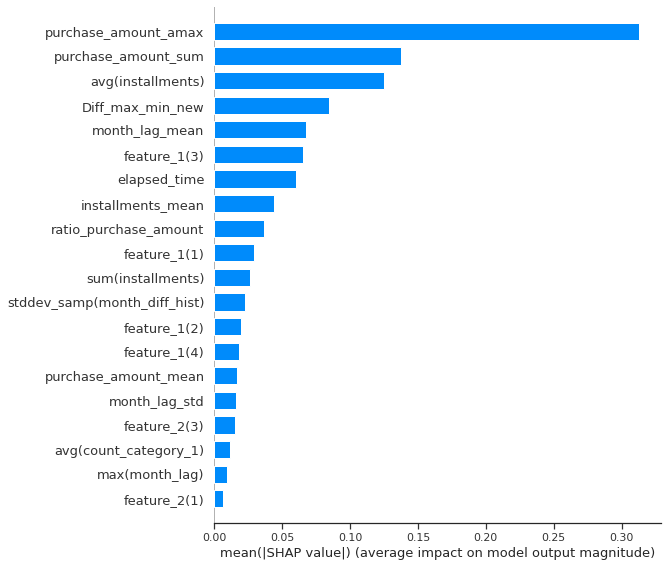

In [78]:
#LPS OSR: Se efectua la estimación con el algoritmo shap para evaluar la contribución cada característica a la predicción.
shap.summary_plot(shap_values, X_test, plot_type="bar")

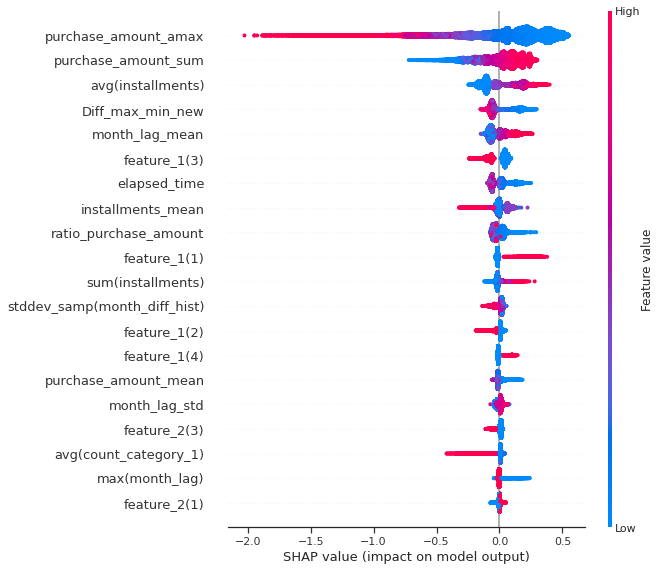

In [79]:
#LPS &OSR: Se gráfica la importancia de las caracteristicas, teniendo en cuenta el rango de impacto en el modelo. 
shap.summary_plot(shap_values, X_test)

In [80]:
#LPS &OSR: Se concatenan dos dataframe  el primero contiene el nombre de las features y el otro la importancia calculada por Xgboots shap
XGBClassifier_3= pd.concat([pd.DataFrame(X.columns, columns=['Features']),pd.DataFrame(np.mean(np.abs(pd.DataFrame(shap_values)),axis=0),columns=['Importance'] )], axis=1)

In [81]:
#LPS &OSR: Se imprimen los valores de la importancia de las feature calculada por xgboots shap que sean inferiores a una centésima del feature important mas alto.
XGBClassifier_3[XGBClassifier_3['Importance']<=np.max(XGBClassifier_3['Importance'])/100]

,Features,Importance
0,max(count_authorized_flag),0.000000
2,sum(count_category_1),0.000212
7,city_id_nunique,0.000799
8,authorized_flag_mean,0.000000
9,authorized_flag_amax,0.000000
10,authorized_flag_std,0.000000
16,month_lag_amax,0.000000
18,month_diff_std,0.002677
26,feature_1(5),0.001220
28,feature_2(2),0.000563


In [82]:
#LPS &OSR: Se imprimen los valores de la importancia de las feature calculados por xgboots que sean inferiores a una centésima del feature important mas alto.
XGBClassifier_3_features=XGBClassifier_3[XGBClassifier_3['Importance']<=np.max(XGBClassifier_3['Importance'])/100]

In [83]:
#LPS &OSR:Se calcula la cantidad de features seleccionadas por su baja importanica
len(XGBClassifier_3_features)

12

#### **3.3.2 Decision Tree Regressor**

In [84]:
#LPS & OSR: Se crea una copia del DataFrame Inicial
X= ELO_DB.copy()

In [85]:
#LPS &OSR: Se convierten en lista la serie de features que se seleccionaron como menos representativas
list(XGBClassifier_3_features['Features'])

['max(count_authorized_flag)',
 'sum(count_category_1)',
 'city_id_nunique',
 'authorized_flag_mean',
 'authorized_flag_amax',
 'authorized_flag_std',
 'month_lag_amax',
 'month_diff_std',
 'feature_1(5)',
 'feature_2(2)',
 'feature_3(0)',
 'feature_3(1)']

In [86]:
#LPS &OSR: Se eliminan del dataset X las variables que fueron menos representativas según el algoritmo  Xgboots Permunation
#LPS& OSR: Se elimina la variable target del dataset 
#LPSR &OSR: Se asigna la variable target  a la variable Y
#LPS&OSR: Los datos se dividen en train y trest con el 20% de datos para test.
X.drop(columns=list(XGBClassifier_3_features['Features']), inplace=True)
X.drop(columns=['target', 'Target_discreta'], inplace=True) 
Y= ELO_DB['Target_discreta']      

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 17)

In [87]:
# LPS &OSR Se instancian los parametros para posteriormente hacer  la busqueda valores de parámetros específicos para un estimador

parameters={"criterion": ['gini', 'entropy'],
            "splitter":["best"],
            "max_depth" : [None, 3,7,20],
            "min_samples_split":[3,7, 40],
            "min_samples_leaf":[1,5,9, 20],
            "max_features":["log2","sqrt",None],
            "max_leaf_nodes":[None,10,50,70,90] }

In [88]:
#LPS &OSR Se instancia el modelo DecisionTree Classifier con un randon_state=42 para obtener siempre las mismas caracteristicas
#LPS&OSR: Se guarda el tiempo antes de iniciar el gridsearch
#LPS&OSR se realiza la busqueda de hiperparametros para el modelo DecisionTreeRegressor por medio de un gridsearch, se intancia ROC_AUC como medida de evaluación 


class_decision_model_FR_Xg3=DecisionTreeClassifier(random_state=42)

start_time = time.time()

tuning_model_FR_Xg3=GridSearchCV(class_decision_model_FR_Xg3,param_grid=parameters,scoring='roc_auc',cv=Kf,verbose=3, n_jobs=-1, return_train_score=True)
tuning_model_FR_Xg3.fit(X_train,Y_train)

Time_FR_Xg3=(time.time() - start_time)

Fitting 3 folds for each of 1440 candidates, totalling 4320 fits


In [89]:
#LPS &OSR: se imprimen los mejores parametros obtenidos y el score de validación
print(tuning_model_FR_Xg3.best_params_)
print('Score de validation',tuning_model_FR_Xg3.best_score_)

{'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': 70, 'min_samples_leaf': 20, 'min_samples_split': 3, 'splitter': 'best'}
Score de validation 0.6418781941744676


In [90]:
#LPS &OSR: Se guardan en una variable los resultados del cross validation
#LPS &OSR: Los resultados se guardan en un dataframe
#LPS&OSR: Se filtan los mejores parametros y se implimen
DT_FR_Xg3_results=tuning_model_FR_Xg3.cv_results_
DT_FR_Xg3=pd.DataFrame(DT_FR_Xg3_results)
DT_FR_Xg3[DT_FR_Xg3['params']==tuning_model_FR_Xg3.best_params_]['mean_train_score']

885    0.655273
Name: mean_train_score, dtype: float64

Se puede evidenciar según el score obtenivo en la curva ROC (0.655), que durante el entrenamiento que se obtiene una clasificación de las clases regular.



In [91]:
#LPS&OSR: Se guardan en la variable mean_train_score_DT_FR_Xg3 los resultados obtenidos con la mejor combinación de hiperparametros
mean_train_score_DT_FR_Xg3=float(DT_FR_Xg3[DT_FR_Xg3['params']==tuning_model_FR_Xg3.best_params_]['mean_train_score'].values[0])

In [92]:
#LPS&OSR: Se intancia el modelo  DecisionTreeClassifier con los mejores hiperparametros y se justa el modelo. El criterio usado para evaluar la calidad del slip es entropy

tuned_hyper_model_FR_Xg3= DecisionTreeClassifier(criterion='entropy', max_depth=None,max_features=None,max_leaf_nodes=70,min_samples_leaf=20, min_samples_split=3, splitter='best')
tuned_hyper_model_FR_Xg3.fit(X_train,Y_train)
y_pred_DTR_FR_Xg3=tuned_hyper_model_FR_Xg3.predict(X_test)

In [93]:
#LPS &OSR: Se guardan lso datos obtenidos en el modelo decision tree classifier
#LPS &OSR: se guarda el score de train, el score de test y el tiempo de ejecución
XG_B_SHAP= ["Xgboost SHAP",mean_train_score_DT_FR_Xg3]
XG_B_SHAP.append(roc_auc_score(Y_test, y_pred_DTR_FR_Xg3))
XG_B_SHAP.append(Time_FR_Xg3)
summary_results.append(XG_B_SHAP)

## **Resumen**

In [94]:
#LPS&OSR: Se crea una lista con los nombres del dataset que se construira con el Dataframe Resumen
Columnas=["Tecnica de reduccion", "DTR roc_auc_score Train", "DTR roc_auc_score Test", "Time_G_Search"]
#LPS&OSR: Se crea el dataframe resumen con las listas guardadas anteriormente en summary_results.
Resumen= pd.DataFrame(summary_results, columns=Columnas)
Resumen

,Tecnica de reduccion,DTR roc_auc_score Train,DTR roc_auc_score Test,Time_G_Search
0,Full data frame,0.658465,0.609777,825.875291
1,Row reduction,0.658465,0.609777,816.850292
2,Row Xgboost,0.658465,0.609777,823.275450
3,Xgboost Permutation,0.658162,0.608574,649.104245
4,Xgboost SHAP,0.655273,0.607555,758.074317


Se puede evidenciar que no existe mucha variabilidad entre los resultados obtenidos por el modelo Decision Tree Classifier en las distintas modalidades de reducción de la dimensionalidad. Esto permite concluir que si bien el rendimiento de los distintos modelos es relativamente bajo, no existiría una penalización del performance del modelo de llegarse a seleccionar un dataset cuya dimensionalidad haya sido reducida, ya sea por filas (Row reduction) o columnas (Feature reduction).

Por esta razón, y considerando como criterio el de seleccionar la base de datos que logre minimizar los tiempos de ejecución en la búsqueda de hiperparámetros del Decision Tree Classifier, se realizara una reducción de dimensionalidad por columnas considerando como tipo de modalidad las características prescindibles encontradas por el tipo Permutation Importance.


## 4. **Selección de la base de datos**

**Xgboost Permutation**

Como se mencionó anteriormente, se eliminarán las características menos importantes encontradas a través del algoritmo Xgboost Permutation.

In [95]:
#LPS &OSR: Se realiza una copia del dataset inicial
#LPS &OSR: Se asignana a una lista las caracteristicas menos importantes.
#LPS &OSR: Se eliminan las caracteristicas con menor importancia.
ELO_DB_VF= ELO_DB.copy()
list(XGBClassifier_2_features['Features'])
ELO_DB_VF.drop(columns=list(XGBClassifier_2_features['Features']), inplace=True)

In [96]:
#LPS &OSR :Se comprueba que el dataset tiene las caracteristicas mas importantes. 
ELO_DB_VF

,avg(installments),sum(installments),stddev_samp(month_diff_hist),purchase_amount_amax,purchase_amount_sum,installments_mean,month_lag_mean,elapsed_time,Diff_max_min_new,ratio_purchase_amount,feature_1(1),feature_1(3),feature_1(4),target,Target_discreta
0,-0.770803,-0.588104,-1.521967,-0.382937,0.452051,-0.694257,1.606217,-0.324967,-0.532158,0.015966,0.0,1.0,0.0,-0.078485,0
1,1.436304,0.180519,-1.521967,0.664175,0.400252,0.259869,1.299888,-0.014008,0.373949,-0.050793,1.0,0.0,0.0,0.014108,1
2,-0.764929,-0.578497,-0.029245,-0.378418,0.262464,-0.694257,0.074571,0.520561,1.129039,-0.029036,0.0,1.0,0.0,1.063681,1
3,-0.770803,-0.588104,0.931254,-0.276500,-3.036007,-0.694257,0.457482,-0.111838,1.280057,-0.018901,0.0,0.0,0.0,-1.530249,0
4,0.201704,-0.136538,-0.012219,-0.117087,-0.515463,0.471897,1.606217,-1.072665,-0.481819,0.009096,0.0,0.0,0.0,1.293800,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167753,-0.685450,-0.472811,1.624602,-0.089502,-0.338797,-0.694257,-1.074164,0.415744,0.373949,-0.020937,0.0,0.0,0.0,-1.135256,0
167754,0.227735,-0.261439,-1.521967,-0.316813,-0.224678,0.532476,1.168604,-1.072665,0.222931,0.013278,0.0,0.0,0.0,-1.200510,0
167755,1.381126,0.161304,-0.274674,-0.248442,0.295428,-0.455725,0.074571,-0.646407,-0.381140,-0.004364,0.0,0.0,0.0,-1.194355,0
167756,-0.012110,-0.492026,0.546434,-0.222434,0.826105,-1.648383,-1.457075,-0.967847,-1.488605,-0.021396,0.0,0.0,0.0,1.148358,1


In [97]:
#LPS &OSR: Se convierte a formato csv el dataframe resultante y se nombre 02_DB.cvs
ELO_DB_VF.to_csv("02_DB_class.csv")

In [98]:
#LPS&OSr: se comprime el archivo csv.
ELO_DB_VF.to_csv('02_DB_class.gz', compression='gzip')

# **Modelados de Clasificación**

En esta sección se desarrollará el modelado de la tarea de Clasificación. Inicialmente los modelos fueron sometidos a dos fases sucesivas para determinar los parametros óptimos a implementar y asi optimizar las métricas de Machine learning  definidas para los modelos de clasificación. 

La metodología se puede resumir en las  siguientes etapas:

1.**Búsqueda aleatoria de hiperparámetros en un rango amplio de valores**

Esta etapa se emplea un RandomizedSerchCV el cual muestre se muestrea un número fijo de configuraciones de parámetros de las distribuciones especificadas, este proceso permiter evaluar dentro un conjunto amplio de hiperametros el valor que mejor se ajusta a los datos. Este dato será el input para la fase 2. 

2.**Búsqueda exhaustiva de hiperparámetros acotados**

En esta etapa se emplean técnicas de validación cruzada con el objetivo de encontrar el valor óptimo de los hiperpárametros delimitando la busqueda a los valores dentro un rango de valores cercados al valor obtendio en la etapa 1

3.**Contrucción y ajuste de los modelos de clasificación**

En los modelos de clasificación, se pueden identificar dos tipos de estrategia: la primera es el ajuste de los modelos simples optimizados a partir de la búsqueda de hiperparámetros, y la segunda estrategia es la utilización de métodos de ensemble considerando como estimadora base a los algoritmos simples que mejores resultados obtuvieron previamente, partiendo de esta manera de los métodos más sencillos hasta los más complejos.





## **Descarga de paquetes**

In [99]:
#LRS &OSR Descarga de paquetes
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

In [100]:
!git clone https://github.com/LuisPortela/ELO.git #LPS & OSR: se clona el repostorio que alberga el documento json para hacer la lectura de datos directamente 
import zipfile                                     #           del API de kaggel
import os
import pandas as pd
os.environ['KAGGLE_CONFIG_DIR'] = "/content/ELO"

fatal: destination path 'ELO' already exists and is not an empty directory.


In [101]:
#LPS &OSR: Se realiza la lectura del archivo 02_DB.gz
ELO_DB = pd.read_csv('ELO/02_DB_class.gz', compression='gzip', header=0, sep=',')

In [102]:
#LPS & OSR: Se elimina la columna  "unnamed:0" obtenida por defecto
ELO_DB.drop(columns=['Unnamed: 0'], inplace=True)

In [103]:
#LPS&OSR Visualización de las dos primeras filas del dataset
ELO_DB.head(2)

,avg(installments),sum(installments),stddev_samp(month_diff_hist),purchase_amount_amax,purchase_amount_sum,installments_mean,month_lag_mean,elapsed_time,Diff_max_min_new,ratio_purchase_amount,feature_1(1),feature_1(3),feature_1(4),target,Target_discreta
0,-0.770803,-0.588104,-1.521967,-0.382937,0.452051,-0.694257,1.606217,-0.324967,-0.532158,0.015966,0.0,1.0,0.0,-0.078485,0
1,1.436304,0.180519,-1.521967,0.664175,0.400252,0.259869,1.299888,-0.014008,0.373949,-0.050793,1.0,0.0,0.0,0.014108,1


In [104]:
# LPS &OSR se crea la function to get_cv_scores que posteriormente servirá para obtener los scores del modelos simples 
def get_cv_scores(model):
    scores = cross_val_score(model,
                             X_train,
                             Y_train,
                             cv=3,
                             scoring='roc_auc')
    
    print('CV Mean: ', np.mean(scores))
    print('STD: ', np.std(scores))

In [105]:
#LPS&OSR: Se define la estrategía de valización cruzada con k=3
Kf= KFold(n_splits=3)

In [106]:
#LPS &OSR Se hace una copia del DataFrame inicial 
#LPS &OSR Se elimina la columna target y target_discreta y se asigna el dataframe resultante a la variable X
#LPS &OSR Se instancia la variable Y con la serie de la columna target   
#LPS&OSR: Los datos se se dividen en train y trest con el 20% de datos para test.
X= ELO_DB.copy()

X= X.drop(columns=['target','Target_discreta']) 
Y= ELO_DB['Target_discreta']      

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 17)

## **1. Modelos simples para clasificación**

En esta etapa se evaluarán modelos de clasificación con el objetivo de predecir la variable objetivo target_discreta, en este sentido, a cada modelo en caso de aplicar se realizará una busqueda y ajuster de los mejores hiperparámetros. 

Los modelos que se evaluarán son los siguientes:

* Simple Logistic Regression
* Logistic Regression Solver: newton-cg, lbfgs, sag
* Logistic Regression Solver: liblinear
* Logistic Regression Solver: saga
* Decision Tree Classifier
* Random Forest Classifier



### **1.1 Logistic Regression (modelo base)**

In [107]:
# LPS &OSR se instancia y se justa el modelo
#LPS&OSRse obtiene los score ROC_AUC de train empleando la función get_cv_scores
LR = LogisticRegression(random_state=42).fit(X_train, Y_train)
get_cv_scores(LR) 

CV Mean:  0.6437529255025042
STD:  0.0022461922228764063


In [108]:
#LPS &OSR se realiza la predición con los datos de test y se imprimen los resultados de la métrica ROC_AUC
Y_pred_LR = LR.predict(X_test)

print('ROC_AUC',roc_auc_score(Y_test, Y_pred_LR))

ROC_AUC 0.6027497731612808


Para el modelo de logistic regression simple se obtuvo un ROC_AUC de 0.60 

### 1.2 **Tuned Logistic Regression**

#### **Random hyperparameters**

En esta sesión se busca hallar un valor cercano al óptimo para los hiperparámetros c y tol del modelo logistc regression. 

In [109]:
#LPS&OSR: se instancian los rangos de los hiperparámetros para el modelo logistic regression
C = [int(x) for x in np.linspace(start = 0.01, stop = 10, num = 1000)]
tol= [int(x) for x in np.linspace(start = 0.0001, stop = 1, num = 1000)]

In [110]:
#LPS&OSR: se guardan las listas en un diccionario.

parameters={"C": C,
            "tol" :tol}

In [111]:
#LPS&OSR: se instancia el modelo
#LPS&OSR: se instancia en la validación,los estimadores, las distribuciones y el número de iteraciones. 
#LPS&OSR: se ajusta el modelo
#LPS&OSR: se imprimen los mejores parametros
LR_random = LogisticRegression(random_state=42)
LR_random = RandomizedSearchCV(estimator = LR_random, param_distributions = parameters, n_iter = 500, scoring='roc_auc', cv = Kf, verbose=0, random_state=42, n_jobs = -1)
LR_random.fit(X_train, Y_train)
LR_random.best_params_


129 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
129 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1614, in fit
    for class_, warm_start_coef_ in zip(classes_, warm_start_coef)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._disp

{'C': 2, 'tol': 1}

Se proceso anterior lo siguientes valores para los hiperparámetros: c=2 y un tol=1

#### **Hyperparameter Tuning**

El proceso de Tuning de este modelo esta dividido en varias etapas

1. Solver: newton-cg, lbfgs, sag
2. Solver: liblinear
3. Solver: saga

##### **Solver: newton-cg, lbfgs, sag**

En esta iteración se buscan determinar dos cosas:el valor óptimo de los hiperparámetros c y tol,
haciendo iteraciones con el método del solver evaluado con: newton-cg, lbfgs, sag

In [112]:
#LPS&OSR: se instancian los rangos de los hiperparámetros cy tol
C = [int(x) for x in np.linspace(start = 1, stop = 5, num = 10)]
tol= [int(x) for x in np.linspace(start = 0.5, stop = 2, num = 10)]

In [113]:
#LPS&OSR: se guardan las listas en un diccionario.
#LPS&OSR: en este caso aplica penalty L2 y none
parameters_LR_3S={"C": C,
                  "tol" :tol, 
                  "penalty":['l2', 'none'],
                  "solver": ['newton-cg' , 'lbfgs' , 'sag']
                  }

In [114]:

#LPS&OSR: Se crea instancia el GridserchCV, con el estimador LR_tuned, score:ROC_AUC,  tecnica de validación kfold
#LPSROSR: se ajsuta el modelo
#LPS&OSR: se imprime el el score de validación obtenido con los mejores parametros


LR_tuned=LogisticRegression(random_state=42)
tuning_model_LR_3S=GridSearchCV(LR_tuned,param_grid=parameters_LR_3S,cv=Kf,verbose=3,scoring='roc_auc', n_jobs=-1, return_train_score=True)
tuning_model_LR_3S.fit(X_train,Y_train)

Fitting 3 folds for each of 600 candidates, totalling 1800 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [1, 1, 1, 2, 2, 3, 3, 4, 4, 5],
                         'penalty': ['l2', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'sag'],
                         'tol': [0, 0, 0, 1, 1, 1, 1, 1, 1, 2]},
             return_train_score=True, scoring='roc_auc', verbose=3)

In [115]:
#LPS&OSR: Se imprimen los mejores parámetros.
print(tuning_model_LR_3S.best_params_)
print('Score de validation',tuning_model_LR_3S.best_score_)

{'C': 1, 'penalty': 'none', 'solver': 'lbfgs', 'tol': 1}
Score de validation 0.6437574823916634


In [116]:
#LPS&OSR: se guardan los mejores parametros en un dataset y se filtran únicamente los datos de la columna mean_train_score

LR_3S_results=tuning_model_LR_3S.cv_results_
df_LR_3S=pd.DataFrame(LR_3S_results)
df_LR_3S[df_LR_3S['params']==tuning_model_LR_3S.best_params_]['mean_train_score']

43     0.643959
44     0.643959
45     0.643959
46     0.643959
47     0.643959
48     0.643959
103    0.643959
104    0.643959
105    0.643959
106    0.643959
107    0.643959
108    0.643959
163    0.643959
164    0.643959
165    0.643959
166    0.643959
167    0.643959
168    0.643959
Name: mean_train_score, dtype: float64

In [117]:
#LPS&OSR: se instancia el modelo con los mejores parámetros y se ajusta. 
#LPS&OSR: se hace una predicción con los valores de X_test
tuned_model_LR_3S= LogisticRegression(C= 1, penalty= 'none', solver= 'lbfgs', tol=1,  random_state=42)
tuned_model_LR_3S.fit(X_train,Y_train)
y_pred_LR_3S=tuned_model_LR_3S.predict(X_test)

In [118]:
#LPS &OSR: se imprimen los valores de test
print('ROC_AUC',roc_auc_score(Y_test, y_pred_LR_3S))

ROC_AUC 0.6027497731612808


##### **Solver: liblinear** 

En esta iteración se buscan determinar dos cosas:el valor óptimo de los hiperparámetros c y tol,
haciendo iteraciones con el método del solver evaluado con: liblenear

In [119]:
#LPS&OSR: se guardan las listas en un diccionario.
#LPS&OSR: en este caso aplica penalty L2 y L1
parameters_LR_1S={"C": C,
                  "tol" :tol, 
                  "penalty":['l1', 'l2'],
                  "solver": ['liblinear']
                  }

In [120]:
#LPS&OSR: Se crea instancia el GridserchCV, con el estimador LR_tuned, score:ROC_AUC,  tecnica de validación kfold
#LPSROSR: se ajsuta el modelo
#LPS&OSR: se imprime el el score de validación obtenido con los mejores parametros

LR_tuned_LR_1S=LogisticRegression(random_state=42)
tuning_model_LR_1S=GridSearchCV(LR_tuned_LR_1S,param_grid=parameters_LR_1S,cv=Kf,verbose=3,scoring='roc_auc', n_jobs=-1, return_train_score=True)
tuning_model_LR_1S.fit(X_train,Y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits



180 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1541, in fit
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 1198, in _fit_liblinear
    sample_weight,
  File "sklearn/svm/_liblinear.pyx", line 52, in sklearn.svm._liblinear.train_wrap
ValueError: b'eps <= 0'

One or more of the test scores are non-finite: [       n

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [1, 1, 1, 2, 2, 3, 3, 4, 4, 5],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear'],
                         'tol': [0, 0, 0, 1, 1, 1, 1, 1, 1, 2]},
             return_train_score=True, scoring='roc_auc', verbose=3)

In [121]:
#LPS&OSR: Se imprimen los mejores parámetros.
print(tuning_model_LR_1S.best_params_)
print('Score de validation',tuning_model_LR_1S.best_score_)

{'C': 5, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 1}
Score de validation 0.6354232992177218


In [122]:
#LPS&OSR: se guardan los mejores parametros en un dataset y se filtran únicamente los datos de la columna mean_train_score

LR_1S_results=tuning_model_LR_1S.cv_results_
df_LR_1S=pd.DataFrame(LR_1S_results)
df_LR_1S[df_LR_1S['params']==tuning_model_LR_1S.best_params_]['mean_train_score']

183    0.635613
184    0.635613
185    0.635613
186    0.635613
187    0.635613
188    0.635613
Name: mean_train_score, dtype: float64

In [123]:
#LPS&OSR: se instancia el modelo con los mejores parámetros y se ajusta. 
#LPS&OSR: se hace una predicción con los valores de X_test
tuned_model_LR_1S= LogisticRegression(C= 5, penalty= 'l1', solver= 'liblinear', tol=1,  random_state=42)
tuned_model_LR_1S.fit(X_train,Y_train)
y_pred_LR_1S=tuned_model_LR_1S.predict(X_test)

In [124]:
#LPS &OSR: se imprimen los valores de test
print('ROC_AUC',roc_auc_score(Y_test, y_pred_LR_1S))

ROC_AUC 0.5920667911442474


##### **Solver: saga** 

In [125]:
#LPS&OSR: se guardan las listas en un diccionario.
#LPS&OSR: en este caso aplica penalty L2, L1, elasticnet' y none
parameters_LR_Saga={"C": C,
                    "tol" :tol, 
                    "penalty":['elasticnet', 'l1', 'l2', 'none'],
                    "solver": ['saga']
                    }

In [126]:
#LPS&OSR: Se crea instancia el GridserchCV, con el estimador LR_tuned, score:ROC_AUC,  tecnica de validación kfold
#LPSROSR: se ajsuta el modelo
#LPS&OSR: se imprime el el score de validación obtenido con los mejores parametros

LR_tuned_LR_Saga=LogisticRegression(random_state=42)

tuning_model_LR_Saga=GridSearchCV(LR_tuned_LR_Saga,param_grid=parameters_LR_Saga,cv=Kf,verbose=3,scoring='roc_auc', n_jobs=-1, return_train_score=True)
tuning_model_LR_Saga.fit(X_train,Y_train)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits



300 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1473, in fit
    % self.l1_ratio
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.64375694 0.64375694
 0.64375694 0.6332423  0.6332423  0.6332423  0

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [1, 1, 1, 2, 2, 3, 3, 4, 4, 5],
                         'penalty': ['elasticnet', 'l1', 'l2', 'none'],
                         'solver': ['saga'],
                         'tol': [0, 0, 0, 1, 1, 1, 1, 1, 1, 2]},
             return_train_score=True, scoring='roc_auc', verbose=3)

In [127]:
#LPS&OSR: Se imprimen los mejores parámetros.
print(tuning_model_LR_Saga.best_params_)
print('Score de validation',tuning_model_LR_Saga.best_score_)

{'C': 1, 'penalty': 'l1', 'solver': 'saga', 'tol': 0}
Score de validation 0.643756937572095


In [128]:
#LPS&OSR: se guardan los mejores parametros en un dataset y se filtran únicamente los datos de la columna mean_train_score

tuning_model_LR_Saga_results=tuning_model_LR_Saga.cv_results_
df_LR_Saga=pd.DataFrame(tuning_model_LR_Saga_results)
df_LR_Saga[df_LR_Saga['params']==tuning_model_LR_Saga.best_params_]['mean_train_score']

10    0.643958
11    0.643958
12    0.643958
50    0.643958
51    0.643958
52    0.643958
90    0.643958
91    0.643958
92    0.643958
Name: mean_train_score, dtype: float64

In [129]:
#LPS&OSR: se instancia el modelo con los mejores parámetros y se ajusta. 
#LPS&OSR: se hace una predicción con los valores de X_test
tuned_model_LR_Saga= LogisticRegression(C= 1, penalty= 'l1', solver= 'saga', tol=0,  random_state=42)
tuned_model_LR_Saga.fit(X_train,Y_train)
y_pred_LR_Saga=tuned_model_LR_Saga.predict(X_test)

The max_iter was reached which means the coef_ did not converge


In [130]:
#LPS &OSR: se imprimen los valores de test
print('ROC_AUC',roc_auc_score(Y_test, y_pred_LR_Saga))

ROC_AUC 0.6027497731612808


### **1.3. Decision Tree Classifier**

#### **Random hyperparameters**

In [131]:
#LPS&OSR: se instancian los rangos de los hiperparámetros para el modelo decision tree Classifier
max_depth = [int(x) for x in np.linspace(start = 2, stop = 20, num = 18)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 40, num = 38)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 20, num = 18)]
max_leaf_nodes = [int(x) for x in np.linspace(start = 2, stop = 100, num = 98)]

In [132]:
 #LPS&OSR: se guardan las listas en un diccionario

parameters={"criterion": ['gini', 'entropy'],
            "splitter":["best"],
            "max_depth" : max_depth,
            "min_samples_split":min_samples_split,
            "min_samples_leaf":min_samples_leaf,
            "max_features":["log2","sqrt",None],
            "max_leaf_nodes":max_leaf_nodes}

In [133]:
#LPS&OSR: se instancia el modelo
#LPS&OSR: se instancia en la validación,los estimadores, las distribuciones y el número de iteraciones. 
#LPS&OSR: se ajusta el modelo
#LPS&OSR: se imprimen los mejores parametros
DTC_random = DecisionTreeClassifier(random_state=42)
DTC_random = RandomizedSearchCV(estimator = DTC_random, param_distributions = parameters, n_iter = 500, scoring='roc_auc', cv = Kf, verbose=2, random_state=42, n_jobs = -1)
DTC_random.fit(X_train, Y_train)
DTC_random.best_params_

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


{'criterion': 'entropy',
 'max_depth': 18,
 'max_features': None,
 'max_leaf_nodes': 93,
 'min_samples_leaf': 10,
 'min_samples_split': 34,
 'splitter': 'best'}

#### **Hyperparameter Tuning**

In [134]:
#LPS&OSR: se instancian los rangos de los hiperparámetros para el modelo decision tree clasifier con rangos cercanos a los mejores
#parámetros encontrados anteriormente
max_depth = [int(x) for x in np.linspace(start = 15, stop = 25, num = 10)]
min_samples_split = [int(x) for x in np.linspace(start = 32, stop = 36, num = 4)]
min_samples_leaf = [int(x) for x in np.linspace(start = 8, stop = 12, num = 4)]
max_leaf_nodes = [int(x) for x in np.linspace(start = 90, stop = 95, num = 5)]

In [135]:
#LPS&OSR: se guardan las listas anteriores en un diccionario.
parameters_GS={"criterion":["entropy"],
                "splitter":["best"],
                "max_depth" : max_depth,
                "min_samples_split":min_samples_split,
                "min_samples_leaf":min_samples_leaf,
                "max_features":[None],
                "max_leaf_nodes":max_leaf_nodes }

In [136]:
#LPS&OSR: Se instancia el modelo decision tree clasifier 
#LPS&OSR: Se crea instancia el GridserchCV, con el estimador reg_decision_model, score:R2,  tecnica de validación kfold
#LPSROSR: se ajsuta el modelo

class_decision_model=DecisionTreeClassifier(random_state=42)

tuning_model=GridSearchCV(class_decision_model,param_grid=parameters_GS,cv=Kf,verbose=3,scoring='roc_auc', n_jobs=-1, return_train_score=True)
tuning_model.fit(X_train,Y_train)

Fitting 3 folds for each of 800 candidates, totalling 2400 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['entropy'],
                         'max_depth': [15, 16, 17, 18, 19, 20, 21, 22, 23, 25],
                         'max_features': [None],
                         'max_leaf_nodes': [90, 91, 92, 93, 95],
                         'min_samples_leaf': [8, 9, 10, 12],
                         'min_samples_split': [32, 33, 34, 36],
                         'splitter': ['best']},
             return_train_score=True, scoring='roc_auc', verbose=3)

In [137]:
#LPS&OSR: se imprime el el score de validación obtenido con los mejores parametros
#LPS&OSR: Se imprimen los mejores parámetros.
print(tuning_model.best_params_)
print('Score de validation',tuning_model.best_score_)

{'criterion': 'entropy', 'max_depth': 15, 'max_features': None, 'max_leaf_nodes': 93, 'min_samples_leaf': 10, 'min_samples_split': 32, 'splitter': 'best'}
Score de validation 0.642175073336921


In [138]:
#LPS&OSR: se guardan los mejores parametros en un dataset y se filtran únicamente los datos de la columna mean_train_score
DT_results=tuning_model.cv_results_
df=pd.DataFrame(DT_results)
df[df['params']==tuning_model.best_params_]['mean_train_score']

56    0.658463
Name: mean_train_score, dtype: float64

In [139]:
#LPS&OSR: Se instancia el modelo con los mejores hiperparámetros encontrados en el gridserch
#LPS&OSR: se ajusta el modelo
#LPS&OSR: se hacen predicciones ocn los datos de test
tuned_hyper_model= DecisionTreeClassifier(criterion= 'entropy',max_depth=15,max_features=None,max_leaf_nodes=93,min_samples_leaf=10, min_samples_split=32, splitter='best', random_state=42)
tuned_hyper_model.fit(X_train,Y_train)
y_pred_DTC=tuned_hyper_model.predict(X_test)

In [140]:
#LPS &OSR: se imprimen las métricas con los valores de  de test
print('ROC_AUC',roc_auc_score(Y_test, y_pred_DTC))

ROC_AUC 0.6077009797174223


### **1.4.Random Forest**

Para el modelo Random Forest, se realizaran dos busquedas de hiperparámetros, en la primera se buscará el valor óptimo de n_estimators y en la segunda parte se hará la busqueda del resto de hiperparámetros.

#### **Random hyperparameters**

**n_estimators**

In [141]:
#LPS&OSR: #LPS&OSR: se instancia en la  varible  n_estimatos un rango de valores entre 10 y 200, en total 100 valores
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 100)]
random_grid = {'n_estimators': n_estimators}

In [142]:
#LPS&OSR: se instancia el modelo
#LPS&OSR: se instancia en la validación,los estimadores, las distribuciones y el número de iteraciones. 
#LPS&OSR: se ajusta el modelo
#LPS&OSR: se imprimen los mejores parametros
rf = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, scoring='roc_auc', cv = Kf, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, Y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'n_estimators': [10, 11, 13, 15, 17, 19,
                                                         21, 23, 25, 27, 29, 31,
                                                         33, 34, 36, 38, 40, 42,
                                                         44, 46, 48, 50, 52, 54,
                                                         56, 57, 59, 61, 63, 65, ...]},
                   random_state=42, scoring='roc_auc', verbose=2)

In [143]:
#LPS&OSR: se imprimen los mejores parametros
rf_random.best_params_

{'n_estimators': 194}

Del proceso anterior se obtiene que el número de estimadores óptimo esta en un rango cercano al valor: 194

**Other Hyperparameters**

In [144]:
#LPS&OSR: se instancian los rangos de los hiperparámetros para el modelo Random Forest
max_depth = [int(x) for x in np.linspace(start = 2, stop = 20, num = 18)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 40, num = 38)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 20, num = 18)]
max_leaf_nodes = [int(x) for x in np.linspace(start = 2, stop = 100, num = 98)]

In [145]:
#LPS&OSR: se guardan las listas anteriores en un diccionario.
parameters_GS_2={"criterion":["entropy", "gini"],
                "n_estimators": [194],
                "max_depth" : max_depth,
                "min_samples_split":min_samples_split,
                "min_samples_leaf":min_samples_leaf,
                "max_features":['auto', 'sqrt', 'log2'],
                "max_leaf_nodes":max_leaf_nodes }

In [146]:
#LPS&OSR: se instancia el modelo
#LPS&OSR: se instancia en la validación,los estimadores, las distribuciones y el número de iteraciones. 
#LPS&OSR: se ajusta el modelo
#LPS&OSR: se imprimen los mejores parametros
rf_2 = RandomForestClassifier(random_state=42)
rf_random_2 = RandomizedSearchCV(estimator = rf_2, param_distributions = parameters_GS_2, n_iter = 50, scoring='roc_auc', cv = Kf, verbose=2, random_state=42, n_jobs = -1)
rf_random_2.fit(X_train, Y_train)
rf_random_2.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'criterion': 'gini',
 'max_depth': 18,
 'max_features': 'sqrt',
 'max_leaf_nodes': 87,
 'min_samples_leaf': 6,
 'min_samples_split': 25,
 'n_estimators': 194}

#### **Hyperparameter Tuning**

In [147]:
#LPS&OSR: se instancian los rangos de los hiperparámetros para el modelo random forest con rangos cercanos a los mejores
#parámetros encontrados anteriormente.
n_estimators = [int(x) for x in np.linspace(start = 194, stop = 195, num = 2)]
max_depth = [int(x) for x in np.linspace(start = 18, stop = 19, num = 2)]
min_samples_split = [int(x) for x in np.linspace(start = 24, stop = 26, num = 3)]
min_samples_leaf = [int(x) for x in np.linspace(start = 24, stop = 26, num = 3)]
max_leaf_nodes = [int(x) for x in np.linspace(start = 86, stop = 88, num = 3)]

In [148]:
#LPS&OSR: se guardan las listas anteriores en un diccionario.
parameters_GS={"criterion":["gini"],
                "max_depth" : max_depth,
                "max_features":['sqrt'],
                "max_leaf_nodes":max_leaf_nodes,
                "min_samples_leaf":min_samples_leaf, 
                "min_samples_split":min_samples_split,
                "n_estimators": n_estimators
                }

In [149]:
#LPS&OSR: se instancia el modelo RandomForestClassifier
#LPS&OSR: Se  instancia la técnica CV GridserchCV, con el estimador RFC, score:roc_acu,  tecnica de validación kfold
#LPSROSR: se ajsuta el modelo

RFC = RandomForestClassifier(random_state=42)
RF_tunning = GridSearchCV(estimator = RFC, param_grid = parameters_GS,  scoring='roc_auc', cv = Kf, verbose=2,  n_jobs = -1, return_train_score=True)
RF_tunning.fit(X_train, Y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [18, 19],
                         'max_features': ['sqrt'],
                         'max_leaf_nodes': [86, 87, 88],
                         'min_samples_leaf': [24, 25, 26],
                         'min_samples_split': [24, 25, 26],
                         'n_estimators': [194, 195]},
             return_train_score=True, scoring='roc_auc', verbose=2)

In [150]:
#LPS&OSR: se imprime el el score de validación obtenido con los mejores parametros
#LPS&OSR: Se imprimen los mejores parámetros.
print(RF_tunning.best_params_)
print('Score de validation',RF_tunning.best_score_)

{'criterion': 'gini', 'max_depth': 18, 'max_features': 'sqrt', 'max_leaf_nodes': 88, 'min_samples_leaf': 26, 'min_samples_split': 24, 'n_estimators': 195}
Score de validation 0.6538756977374904


In [151]:
#LPS&OSR: se guardan los mejores párametros en un dataset y se filtran únicamente los datos de la columna mean_train_score

RF_results=RF_tunning.cv_results_
RF_results_df=pd.DataFrame(RF_results)
RF_results_df[RF_results_df['params']==RF_tunning.best_params_]['mean_train_score']

49    0.669983
Name: mean_train_score, dtype: float64

In [152]:
#LPS&OSR: Se instancia el modelo con los mejores hiperparámetros encontrados en el gridsearchCV
#LPS&OSR: se ajusta el modelo
#LPS&OSR: se hacen predicciones ocn los datos de test
tuned_hyper_model_RF= RandomForestClassifier(criterion= 'gini', max_depth= 18, max_features= 'sqrt', max_leaf_nodes= 88, min_samples_leaf= 26, min_samples_split=24, n_estimators= 195)
tuned_hyper_model_RF.fit(X_train,Y_train)

RandomForestClassifier(max_depth=18, max_features='sqrt', max_leaf_nodes=88,
                       min_samples_leaf=26, min_samples_split=24,
                       n_estimators=195)

In [153]:
#LPS&OSR: se hacen predicciones ocn los datos de test
y_pred_RFC=tuned_hyper_model_RF.predict(X_test)

In [154]:
#LPS &OSR: se imprimen las métricas con los valores de  de test
print('ROC_AUC',roc_auc_score(Y_test, y_pred_RFC))

ROC_AUC 0.6060915731637839


### **Conclusión modelos simples**

La métrica no mejora según la complejidad del algoritmo empleado. En este sentido, indistintamente al algoritmo evaluado, el ROC score asociado a la fase de test alcanza un valor máximo cercano al 60%.

## **2. Métodos de ensamble**

Para la tarea de clasificación, se emplearon los métodos de ensamble **VotingClassifier, BaggingClassifier y AdaBoostClassifier** considerando como estimadores bases los modelos simples que presentaron los mejores resultados. Si bien, los rendimientos obtenidos a partir de los modelos simples varían muy poco entre ellos, se seleccionaron como estimadores aquellos que presentaron los resultados más altos.

###**2.1 Voting Classifier**

En esta sección ninguna estrategia de búsqueda de hiperparámetros fue necesaria para emplear este meta-modelo. Por el contrario, se consideraron tres modelos base para llevar a cabo la votación, los cuales corresponden a los dos mejores modelos simples obtenidos en la Logistic Regression asociados a los solvers  lbfgs y saga y al Decision Tree Classifier.

In [155]:
#LSP&OSR: Para el voting classifier se instancian tres modelos: 
#Logistic Regression asociados a los solvers lbfgs y saga y al Decision Tree Classifier
#Se ajusta el modelo

tuned_model_LR_3S= LogisticRegression(C= 1, penalty= 'none', solver= 'lbfgs', tol=1,  random_state=42)
tuned_model_LR_Saga= LogisticRegression(C= 1, penalty= 'l1', solver= 'saga', tol=0,  random_state=42)
tuned_hyper_model_DT= DecisionTreeClassifier(criterion= 'entropy',max_depth=15,max_features=None,max_leaf_nodes=93,min_samples_leaf=10, min_samples_split=32, splitter='best', random_state=42)

clf = VotingClassifier([('LR_1', tuned_model_LR_3S), ('LR_2', tuned_model_LR_Saga), ('DT', tuned_hyper_model_DT)]).fit(X_train, Y_train)

The max_iter was reached which means the coef_ did not converge


In [156]:
#LPS&OSR: Se realiza la predicción con el modelo entrendo
y_pred_Voting_train= clf.predict(X_train)
print('ROC_AUC',roc_auc_score(Y_train, y_pred_Voting_train))

ROC_AUC 0.6033370655438294


In [157]:
#LPS&OSR: se hacen predicciones con los datos de test
y_pred_Voting= clf.predict(X_test)
print('ROC_AUC',roc_auc_score(Y_test, y_pred_Voting))

ROC_AUC 0.6027497731612808


### **2.2 Bagging Classifier**

Se realiza un método de ensamble para los mejores modelos simples obtenidos anteriormente conservando los valores de los hiperparámetros optimizados. El método de ensemble empleado es el Bagging Classifier, considerando como estimadores base: Logistic Regression y Decision Tree Classifier.

El meta-modelo Bagging  tiene como hiperparámetro principal el número de estimadores (n_estimators). Por consiguiente, con el fin de determinar el valor óptimo del número de estimadores, un proceso iterativo a través de un ciclo for se realizó considerando diferentes valores enteros comprendidos entre 10 y 100 para n_estimators.

#### **2.2.1 Bagging Classifier DTR**

**Determinacion el número de estimadores**

In [158]:
# LPS&OSR: Se realiza un proceso iterativo para encontrar el n_estimators optimo,
# los valores son guardados en el dataframe  Df_bagging
DF_Bagging=pd.DataFrame()
idx=0
r2=0

estimators = [int(x) for x in np.linspace(start=10, stop=100, num=10)]
clf_b = DecisionTreeClassifier(criterion= 'entropy',max_depth=15,max_features=None,max_leaf_nodes=93,min_samples_leaf=10, min_samples_split=32, splitter='best', random_state=42)

for i in estimators:
  Bagging_DT= BaggingClassifier(base_estimator=clf_b, n_estimators=i, random_state=0, n_jobs=-1).fit(X_train, Y_train)
  y_pred_bagging = Bagging_DT.predict(X_test)
  roc_auc=roc_auc_score(Y_test, y_pred_bagging)

  DF_Bagging.loc[idx, "Estimadores"]=i
  DF_Bagging.loc[idx, "roc_auc"]=roc_auc

  idx+=1

In [159]:
# LPS&OSR: se imprime el n_estimator mas óptimo según el roc_auc en test
DF_Bagging.sort_values(by='roc_auc', ascending=False).head(1)

,Estimadores,roc_auc
5,60.0,0.6115


In [160]:
#LPS&OSR: se instancia el modelo DecisionTreeClassifier con los mejores parámetros encontrados anteriormente
#LPS&OSR: instancia el bagginclassifier ocn n_estimators=100
Bagging_DTC = DecisionTreeClassifier(criterion= 'entropy',max_depth=15,max_features=None,max_leaf_nodes=93,min_samples_leaf=10, min_samples_split=32, splitter='best', random_state=42)
Bagging_DTC_Tunned = BaggingClassifier(base_estimator=Bagging_DTC, n_estimators=60, random_state=0).fit(X_train, Y_train)

In [161]:
#LPS&OSR se obtiene los score de train empleando la función get_cv_scores
get_cv_scores(Bagging_DTC_Tunned)

CV Mean:  0.653238165983833
STD:  0.0030109891036618226


In [162]:
#LPS &OSR se realiza la predición con los datos de test y se imprimen los resultados de la metrica ROC_AUC
Y_pred_Bagging_DTC_Tunned = Bagging_DTC_Tunned.predict(X_test)
print('ROC_AUC',roc_auc_score(Y_test, Y_pred_Bagging_DTC_Tunned))

ROC_AUC 0.6114995142145757


#### **2.2.2 Bagging Logistic Regresion**

In [163]:
# LPS&OSR: Se realiza un proceso iterativo para encontrar el n_estimators optimo,
# los valores son guardados en el dataframe  Df_bagging
#se instanciael modelo LR con los valores optimos encontrados anteriormente
DF_Bagging_LR=pd.DataFrame()
idx=0
r2=0

estimators = [int(x) for x in np.linspace(start=10, stop=50, num=5)]

#estimators=[10]

tuned_model_LR_3S= LogisticRegression(C= 1, penalty= 'none', solver= 'lbfgs', tol=1,  random_state=42)


for i in estimators:
  Bagging_LR= BaggingClassifier(base_estimator=tuned_model_LR_3S, n_estimators=i, random_state=0, n_jobs=-1).fit(X_train, Y_train)
  y_pred_bagging_LR = Bagging_LR.predict(X_test)
  roc_auc=roc_auc_score(Y_test, y_pred_bagging_LR)

  DF_Bagging_LR.loc[idx, "Estimadores"]=i
  DF_Bagging_LR.loc[idx, "roc_auc"]=roc_auc

  idx+=1

In [164]:
# LPS&OSR: se imprime el n_estimator mas óptimo según el roc_auc en test
DF_Bagging_LR.sort_values(by='roc_auc', ascending=False).head(1)

,Estimadores,roc_auc
3,40.0,0.602592


In [165]:
#LPS&OSR: instancia el BaggingClassifier con n_estimators=40
#LPS&OSR: se instanica el LogisticRegression con los parámetros óptimos.
Bagging_LR = LogisticRegression(C= 1, penalty= 'none', solver= 'lbfgs', tol=1,  random_state=42)
Bagging_LR_Tunned = BaggingClassifier(base_estimator=Bagging_LR, n_estimators=40, random_state=0).fit(X_train, Y_train)

In [166]:
#LPS&OSR se obtiene los score de train empleando la función get_cv_scores
get_cv_scores(Bagging_LR_Tunned)

CV Mean:  0.6437132680225323
STD:  0.0022779035298020785


In [167]:
#LPS &OSR se realiza la predición con los datos de test y se imprimen los resultados de la metrica roc_auc

Y_pred_Bagging_LR_Tunned = Bagging_LR_Tunned.predict(X_test)
print('ROC_AUC',roc_auc_score(Y_test, Y_pred_Bagging_LR_Tunned))

ROC_AUC 0.6025922066559071


### **2.3 Boosting Classifier**

Dado que este metamodelo tiene dos hiperparámetros para optimizar, la estrategia empleada para encontrar los mejores valores es una búsqueda inicial de hiperparámetros aleatorios para acotar el rango de valores y posteriormente, una búsqueda exhaustiva cercana a los valores encontrados previamente.

#### **Random hypermarameters**

In [168]:
#LPS&OSR: se instancian los rangos de los hiperparámetros para AdaBoostClassifier
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 100)]
learning_rate = [int(x) for x in np.linspace(start = 1, stop = 5, num = 100)]

 #LPS&OSR: se guardan las listas en un diccionario.
parameters= {'n_estimators': n_estimators,
             'learning_rate':learning_rate}

In [169]:
#LPS&OSR: se instanica el modelo DecisionTreeClassifier con los parámetros óptimos.
#LPS&OSR: instancia el  AdaBoostClassifier para posteriormente hacer la busqueda de hiperparámetros. 
Boosting_DTC = DecisionTreeClassifier(criterion= 'entropy',max_depth=15,max_features=None,max_leaf_nodes=93,min_samples_leaf=10, min_samples_split=32, splitter='best', random_state=42)
AdaBoosting_DTC = AdaBoostClassifier(base_estimator=Boosting_DTC, random_state=42)

In [170]:
#LPS&OSR: se instancia el modelo
#LPS&OSR: se instancia la técnica de validación RandomizedSearchCV , las distribuciones y el número de iteraciones. 
#LPS&OSR: se ajusta el modelo
AdaBoosting_DTC_random = RandomizedSearchCV(estimator = AdaBoosting_DTC, param_distributions = parameters, n_iter = 20,  scoring='roc_auc', cv = Kf, verbose=3, random_state=42, n_jobs = -1)
AdaBoosting_DTC_random.fit(X_train, Y_train)
AdaBoosting_DTC_random.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


{'learning_rate': 2, 'n_estimators': 33}

### 7.1.2 Hyperparameter Tuning

In [171]:
#LPS&OSR: se instancian los rangos de los hiperparámetros para el modelo boosting Classifier

n_estimators = [int(x) for x in np.linspace(start = 30, stop = 35, num = 5)]
learning_rate = [int(x) for x in np.linspace(start = 1.8, stop = 2.2, num = 5)]

#LPS&OSR: se guardan las listas anteriores en un diccionario.
parameters_tuned= {'n_estimators': n_estimators,
                  'learning_rate':learning_rate}

In [172]:
#LPS&OSR: Se instancia el GridserchCV, con el estimador AdaBoosting_DTC
#LPSROSR: se ajsuta el modelo
#LPS&OSR: se imprime el el score de validación obtenido con los mejores parametros
#LPS&OSR: Se imprimen los mejores parámetros.
AdaBoosting_DTC_Tuned = GridSearchCV(estimator=AdaBoosting_DTC, param_grid = parameters_tuned, scoring='roc_auc', cv = Kf, verbose=3, n_jobs = -1,return_train_score=True)
AdaBoosting_DTC_Tuned = AdaBoosting_DTC_Tuned.fit(X_train, Y_train)

print('Best Score: ', AdaBoosting_DTC_Tuned.best_score_)
print('Best Params: ', AdaBoosting_DTC_Tuned.best_params_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best Score:  0.6204256709440802
Best Params:  {'learning_rate': 2, 'n_estimators': 31}


In [173]:
#LPS&OSR: se guardan los mejores parametros en un dataset y se filtran únicamente los datos de la columna mean_train_score
AdaBoosting_DTC_results=AdaBoosting_DTC_Tuned.cv_results_
AdaBoosting_DTC_df=pd.DataFrame(AdaBoosting_DTC_results)
AdaBoosting_DTC_df[AdaBoosting_DTC_df['params']==AdaBoosting_DTC_Tuned.best_params_]['mean_train_score']

11    0.695292
16    0.695292
21    0.695292
Name: mean_train_score, dtype: float64

In [174]:
#LPS&OSR: Se instancia el modelo con los mejores hiperparámetros encontrados en el gridserch
#LPS&OSR: se ajusta el modelo
AdaBoost_DTC_tuned = AdaBoostClassifier(base_estimator=Boosting_DTC, random_state=42 , n_estimators=33, learning_rate=2).fit(X_train, Y_train)

In [175]:
#LPS &OSR: se imprimen las métricas con los valores de  de test
Y_pred_AdaBoost_DTC= AdaBoost_DTC_tuned.predict(X_test)
print('ROC_AUC',roc_auc_score(Y_test, Y_pred_AdaBoost_DTC))

ROC_AUC 0.5967309974347883


### **Conclusión modelos de ensamble**

Se logra evidenciar que los resultados obtenidos en ROC score para los valores de test con los metamodelos utilizados no son necesariamente mejores a las métricas ya obtenidas por los modelos simples.

Por esta razón, de llegarse a seleccionar el mejor modelo para la tarea de clasificación, considerando tanto el rendimiento predictivo del algoritmo con los datos de Test como la capacidad computacional, este sería el modelo simple Decision Tree Classifier. 
